In [1]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy import sparse

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline

### $ \frac{\partial p}{\partial t} = - \frac{\partial}{\partial x} [ \mu(x,t) p(x,t) ] + \frac{\partial^2}{\partial x^2} [ D(x,t) p(x,t) ]$

In [104]:
class FP_diffusion:
    
    def __init__(self, X, dx2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dx2 
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
               
class FP_drift:
    
    def __init__(self, X, dx):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
    
class FokkerPlanck_1D:
    
    def __init__(self, X, mu, D, spatial_order=4):
      
        self.X = X
        p = self.X.field_list[0]
        self.domain = p.domain
        
        dx = FiniteDifferenceUniformGrid(1, spatial_order, p*mu)
        dx2 = FiniteDifferenceUniformGrid(2, spatial_order, p*D)
        
        self.operators = [FP_drift(X, dx),
                          FP_diffusion(X, dx2)] 
            
        self.ts_list   = [CrankNicolson(self.operators[0],axis=0),
                          CrankNicolson(self.operators[1],axis=0)]     
        
        self.t = 0.
        self.iter = 0
        
    def step(self, dt):

        self.ts_list[1].step(dt)
        self.ts_list[0].step(dt)
        #self.ts_list[0].step(dt/2.)
        self.t += dt
        self.iter += 1

In [138]:
resolution = 200
alpha = .1
spatial_order = 4

grid = field.UniformPeriodicGrid(resolution,2*np.pi)
domain = field.Domain([grid])
x = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])
r = np.array([x])-np.pi
IC = np.exp(-r**2*8)
p.data[:]=IC
gamma=0.5
#mu = field.Array(domain,0.5*np.ones(p.data.shape))
D = field.Array(domain,0.1*np.ones(p.data.shape))

mu= field.Array(domain,domain.grids[0].values*(gamma))
print(p.data.shape)


diff = FokkerPlanck_1D(X,mu,D)

tmax = 1-1e-5

dt = alpha * grid.dx

while diff.t < tmax:
    diff.step(dt)

(200,)


/home/fulya/packages/anaconda3/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


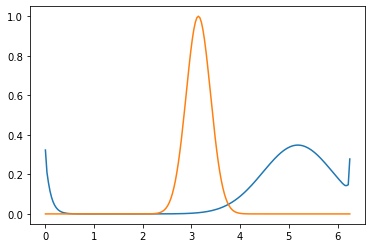

In [139]:
plt.plot(x[0],p.data)
plt.plot(x[0],IC[0][0])

In [110]:
print(domain.__dict__)

{'dimension': 1, 'grids': [<field.UniformPeriodicGrid object at 0x7f925f44bee0>], 'shape': [100]}


In [119]:
print(domain.grids[0].values)

[0.         0.06283185 0.12566371 0.18849556 0.25132741 0.31415927
 0.37699112 0.43982297 0.50265482 0.56548668 0.62831853 0.69115038
 0.75398224 0.81681409 0.87964594 0.9424778  1.00530965 1.0681415
 1.13097336 1.19380521 1.25663706 1.31946891 1.38230077 1.44513262
 1.50796447 1.57079633 1.63362818 1.69646003 1.75929189 1.82212374
 1.88495559 1.94778745 2.0106193  2.07345115 2.136283   2.19911486
 2.26194671 2.32477856 2.38761042 2.45044227 2.51327412 2.57610598
 2.63893783 2.70176968 2.76460154 2.82743339 2.89026524 2.95309709
 3.01592895 3.0787608  3.14159265 3.20442451 3.26725636 3.33008821
 3.39292007 3.45575192 3.51858377 3.58141563 3.64424748 3.70707933
 3.76991118 3.83274304 3.89557489 3.95840674 4.0212386  4.08407045
 4.1469023  4.20973416 4.27256601 4.33539786 4.39822972 4.46106157
 4.52389342 4.58672527 4.64955713 4.71238898 4.77522083 4.83805269
 4.90088454 4.96371639 5.02654825 5.0893801  5.15221195 5.2150438
 5.27787566 5.34070751 5.40353936 5.46637122 5.52920307 5.592034